# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks. Below we demonstate how to train and test a random forest classifier using the Santander Customer Satisfaction dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Classification Using Random Forests

The random forest algorithm is an ensemble learning method used for supervised classification and regression problems. Random Forests combine multiple decision trees and output an average prediction.

A random forest is a collection (often large) of decision trees, each fitted to a subset of the data. A standard choice for a subset is to randomly choose 50% of the datapoints (rows) and take $\sqrt[p]{p}$ of the  p  features (columns). A decision tree is fitted to each subset until the desired number of trees have been grown in the random forest.

The technique of fitting weakly-predictive models to subsets of the data is called bagging (bootstrap aggregation).

Random Forests can:
- Manage a mixture of discrete, continuous and categorical inputs.
- Use data with no normalization/pre-processing (including missing data).
- Incorporate a large number of trees without overfitting.

For these reasons, random forests are the preferred machine learning algorithm in many applications, even over neural networks.

Further discussion of Random Forests can be found in the Wikipedia article [Random forest](https://en.wikipedia.org/wiki/Random_forest) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

## Santander Customer Satisfaction Data

The [Santander Customer Satisfaction Dataset](https://www.kaggle.com/c/santander-customer-satisfaction) is a database consisting of data from 76,020 Santander customers. There are 370 features for each customer, along with a field indicating whether they were satisfied customers or not.

---

### Load data
In the cell below, we load in the utilities library from the [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the Santander Customer Satisfaction dataset.

In [1]:
/ load toolkit and graphics functions
\l ../utils/graphics.q
\l ../utils/util.q
\l ml/ml.q
.ml.loadfile`:util/init.q

In [2]:
show 5#data:((370#"F"),"I";(),",")0:`:../data/santander.csv

/ Inspect data
-1"\nShape of feature data is: "," x "sv string .ml.shape delete TARGET from data;
-1"\nDistribution of target values:\n";
show update pcnt:.01*floor .5+10000*num%sum num from select num:count i by TARGET from data;

ID var3 var15 imp_ent_var16_ult1 imp_op_var39_comer_ult1 imp_op_var39_comer_u..
-----------------------------------------------------------------------------..
1  2    23    0                  0                       0                   ..
3  2    34    0                  0                       0                   ..
4  2    23    0                  0                       0                   ..
8  2    37    0                  195                     195                 ..
10 2    39    0                  0                       0                   ..

Shape of feature data is: 76020 x 370

Distribution of target values:

TARGET| num   pcnt 
------| -----------
0     | 73012 96.04
1     | 3008  3.96 


Classes are highly unbalanced:
- `96%` are satisfied (0)
- `4%` of clients are dissatisfied (1)

A classifier that naively predicted that all clients were satisfied, would therefore achieve nearly 96% accuracy on this dataset. However, such a model would not be of much use in predicting customer churn.

---

### Prepare data
Before we can train a model we need to split the original data into training and testing sets. In this notebook we have chosen to use a 67/33 train/test split.

In [3]:
\S 123  / random seed
show count each datadict:.ml.traintestsplit[flip value flip delete TARGET from data;data`TARGET;.33]

xtrain| 50933
ytrain| 50933
xtest | 25087
ytest | 25087


---

### Fit and evaluate models
Here we create a function to build, fit and evaluate the classifiers.

In [4]:
score:{[y;ypred;yprob]
 `loss`acc`auc!(.ml.logloss;.ml.accuracy;.ml.rocaucscore).'(y;)each(yprob;ypred;yprob[;1])}

results:{[data;clf;name;clfkwargs;ntrees]
 clf:rf[`n_estimators pykw ntrees;pykwargs clfkwargs];
 clf[`:fit][xnp:npa data`xtrain;data`ytrain];
    
 ytrnprob:clf[`:predict_proba;<;xnp];
 ytrnpred:raze imax each ytrnprob;
 ytstprob:clf[`:predict_proba;<;npa data`xtest];
 ytstpred:raze imax each ytstprob;
  
 trnscore:score[data`ytrain;ytrnpred;ytrnprob];
 tstscore:score[data`ytest ;ytstpred;ytstprob];
    
 -1 name," (",string[ntrees]," trees)";
 -1"Training log loss: ",string[trnscore`loss],", accuracy: ",raze[string trnscore`acc],", ROC: ",string trnscore`auc;
 -1"Testing  log loss: ",string[tstscore`loss],", accuracy: ",raze[string tstscore`acc],", ROC: ",string tstscore`auc;
 -1"\n";}

Now we will fit random forest classifiers with 1, 5, 10, 50 and 100 trees on the training data and evaluate their performance on the held-out test data. 

In [5]:
rf:.p.import[`sklearn.ensemble]`:RandomForestClassifier
ntrees:1 5 10 50 100
rfkwargs:enlist[`class_weight]!enlist`balanced
results[datadict;rf;"Random Forest Classifier";rfkwargs]each ntrees;

/home/deanna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Random Forest Classifier (1 trees)
Training log loss: 0.8896958, accuracy: 0.9742407, ROC: 0.8246829
Testing  log loss: 2.379041, accuracy: 0.9311197, ROC: 0.545622


Random Forest Classifier (5 trees)
Training log loss: 0.0387587, accuracy: 0.9912041, ROC: 0.9951927
Testing  log loss: 0.9228899, accuracy: 0.9536812, ROC: 0.629615


Random Forest Classifier (10 trees)
Training log loss: 0.03014381, accuracy: 0.9912238, ROC: 0.9997654
Testing  log loss: 0.7008561, accuracy: 0.9575477, ROC: 0.6855585


Random Forest Classifier (50 trees)
Training log loss: 0.02863277, accuracy: 0.9991754, ROC: 1
Testing  log loss: 0.3388562, accuracy: 0.9579862, ROC: 0.7679301


Random Forest Classifier (100 trees)
Training log loss: 0.02829734, accuracy: 0.9999607, ROC: 1
Testing  log loss: 0.2580249, accuracy: 0.9577869, ROC: 0.7869802




---

### Results

Accuracy is significantly better on the training data than the test data. Near-perfect accuracy suggests that the model has effectively memorized the training dataset.

Given that the goal is to create a model which is able to generalize to unseen datasets, we must be wary of overfitting.

Below we plot the ROC curve for 100 trees to showcase model performance.

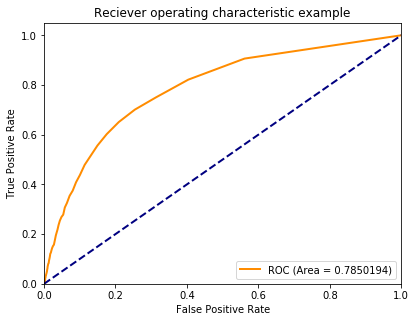

In [6]:
clf:rf[`n_estimators pykw 100;`class_weight pykw`balanced];
clf[`:fit][datadict`xtrain;datadict`ytrain];
yprob:clf[`:predict_proba;<]datadict`xtest

displayROC[datadict`ytest;yprob[;1]];

---

### Dealing with overfitting

Overfitting can be controlled by reducing the degree of freedom of the model, such as the depth of the trees that the algorithm constructs. We therefore repeat the exercise above, restricting the tree depth to 4.

In [7]:
rfkwargs:`class_weight`max_depth!(`balanced;4)
results[datadict;rf;"Random Forest Classifier";rfkwargs;]each ntrees;

Random Forest Classifier (1 trees)
Training log loss: 0.5639564, accuracy: 0.8151297, ROC: 0.7516517
Testing  log loss: 0.5625851, accuracy: 0.8173955, ROC: 0.7380302


Random Forest Classifier (5 trees)
Training log loss: 0.5644256, accuracy: 0.7182966, ROC: 0.7919878
Testing  log loss: 0.5673442, accuracy: 0.7150716, ROC: 0.7857758


Random Forest Classifier (10 trees)
Training log loss: 0.5680165, accuracy: 0.7252273, ROC: 0.7969736
Testing  log loss: 0.5695362, accuracy: 0.723841, ROC: 0.7855676


Random Forest Classifier (50 trees)
Training log loss: 0.5620359, accuracy: 0.721222, ROC: 0.8043629
Testing  log loss: 0.5639153, accuracy: 0.7188185, ROC: 0.7964441


Random Forest Classifier (100 trees)
Training log loss: 0.5692624, accuracy: 0.7187678, ROC: 0.801497
Testing  log loss: 0.5709876, accuracy: 0.7164268, ROC: 0.7956624




Overfitting is certainly eliminated by restricting the tree depth.

Looking at the test results:
- The ROC measure is comparable to previous classifiers.
- The accuracy has reduced.

Looking again at the ROC curve for 100 trees:

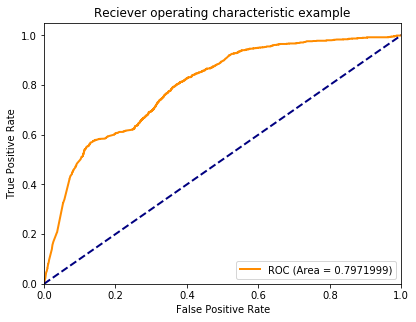

In [8]:
clf:rf[`n_estimators pykw 100;`max_depth pykw 4;`class_weight pykw`balanced];
clf[`:fit][datadict`xtrain;datadict`ytrain];
yprob:clf[`:predict_proba;<]datadict`xtest

displayROC[datadict`ytest;yprob[;1]];

---

### XGBoost

XGBoost is a random forest algorithm that combines the bagging technique with a further addition called boosting.

Boosting works by increasing the weighting on examples that have been misclassified in the past.

The XGBoost algorithm also allows significantly more control over the bagging procedure than Sklearn's default random forest classifier does (Sklearn's default random forest algorithm allows only 100% sampling with replacement of the training data. XGBoost allows control over the % of the training set that is sampled for individual trees, and whether this sampling is done with replacement, or not).

Further information can be found on the [XGBoost website](https://xgboost.readthedocs.io/en/latest/).

We will repeat the process of training again with an XGB classifier to see how results are affected.

In [9]:
xgb:.p.import[`xgboost]`:XGBClassifier
rfkwargs:enlist[`max_depth]!enlist 4
results[datadict;xgb;"XGB Classifier";rfkwargs;]each ntrees;

XGB Classifier (1 trees)
Training log loss: 0.141176, accuracy: 0.9606346, ROC: 0.7985243
Testing  log loss: 0.1427577, accuracy: 0.9600191, ROC: 0.8006471


XGB Classifier (5 trees)
Training log loss: 0.1511053, accuracy: 0.9606346, ROC: 0.7569485
Testing  log loss: 0.1542109, accuracy: 0.9600191, ROC: 0.7494201


XGB Classifier (10 trees)
Training log loss: 0.146016, accuracy: 0.9606346, ROC: 0.7984406
Testing  log loss: 0.1489788, accuracy: 0.9600191, ROC: 0.7903111


XGB Classifier (50 trees)
Training log loss: 0.1465422, accuracy: 0.9606346, ROC: 0.8018069
Testing  log loss: 0.1497293, accuracy: 0.9600191, ROC: 0.7933119


XGB Classifier (100 trees)
Training log loss: 0.1476033, accuracy: 0.9606346, ROC: 0.8029013
Testing  log loss: 0.1509611, accuracy: 0.9600191, ROC: 0.7939213




These results show a significant improvement, in terms of both accuracy and ROC scores.

Furthermore, plotting the ROC curve for 100 trees gives:

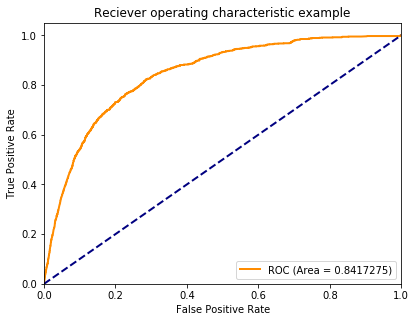

In [10]:
clf:xgb[`n_estimators pykw 100;`max_depth pykw 4];
clf[`:fit][npa datadict`xtrain;npa datadict`ytrain];
yprob:clf[`:predict_proba;<]npa datadict`xtest

displayROC[datadict`ytest;yprob[;1]];

The XGB classifier with 100 trees attains a ROC value of 0.85. This is equal to the highest result recorded in Kaggle for this dataset.

---